In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil
import math
from gaussian_functions import *
from DM_halo_functions import *
from GC_functions import *
from modified_GC_functions import *
from Re_functions import *
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Simulation points

In [2]:
R_es = [2.7, 2.8, 2.9, 3,
       3.1, 3.2, 3.4, 3.5, 3.6]

GC_masses = [5.0, 5.5, 5.7, 5.8, 5.9,
             6, 6.1, 6.2, 6.3, 6.4, 6.5, 
             6.6, 6.7, 6.8, 6.9, 7, 7.1, 7.2, 7.3, 7.4, 8]

halo_masses = [ 9, 9.75, 10.5, 11.25, 12]

In [3]:
# # Create 3D scatter plot
# R_es_mesh, GC_masses_mesh, halo_masses_mesh = np.meshgrid(R_es, GC_masses, 
#                                                           halo_masses, 
#                                                           indexing='ij')

# # Flatten the arrays for plotting
# R_es = R_es_mesh.flatten()
# GC_masses = GC_masses_mesh.flatten()
# halo_masses = halo_masses_mesh.flatten()


# d3_plot(R_es, GC_masses, halo_masses, elev=1, azim=2)

In [4]:
grid_data = np.load("grid_merger_classification.npy")
R_es, GC_masses, halo_masses, mergers = grid_data[:, 0], grid_data[:, 1], grid_data[:, 2], grid_data[:, 3]
print(len(R_es))
print(len(GC_masses))
print(len(halo_masses))
print(len(mergers))

747
747
747
747


<Axes3DSubplot:xlabel='log Halo Mass M*', ylabel='log GC Mass M*'>

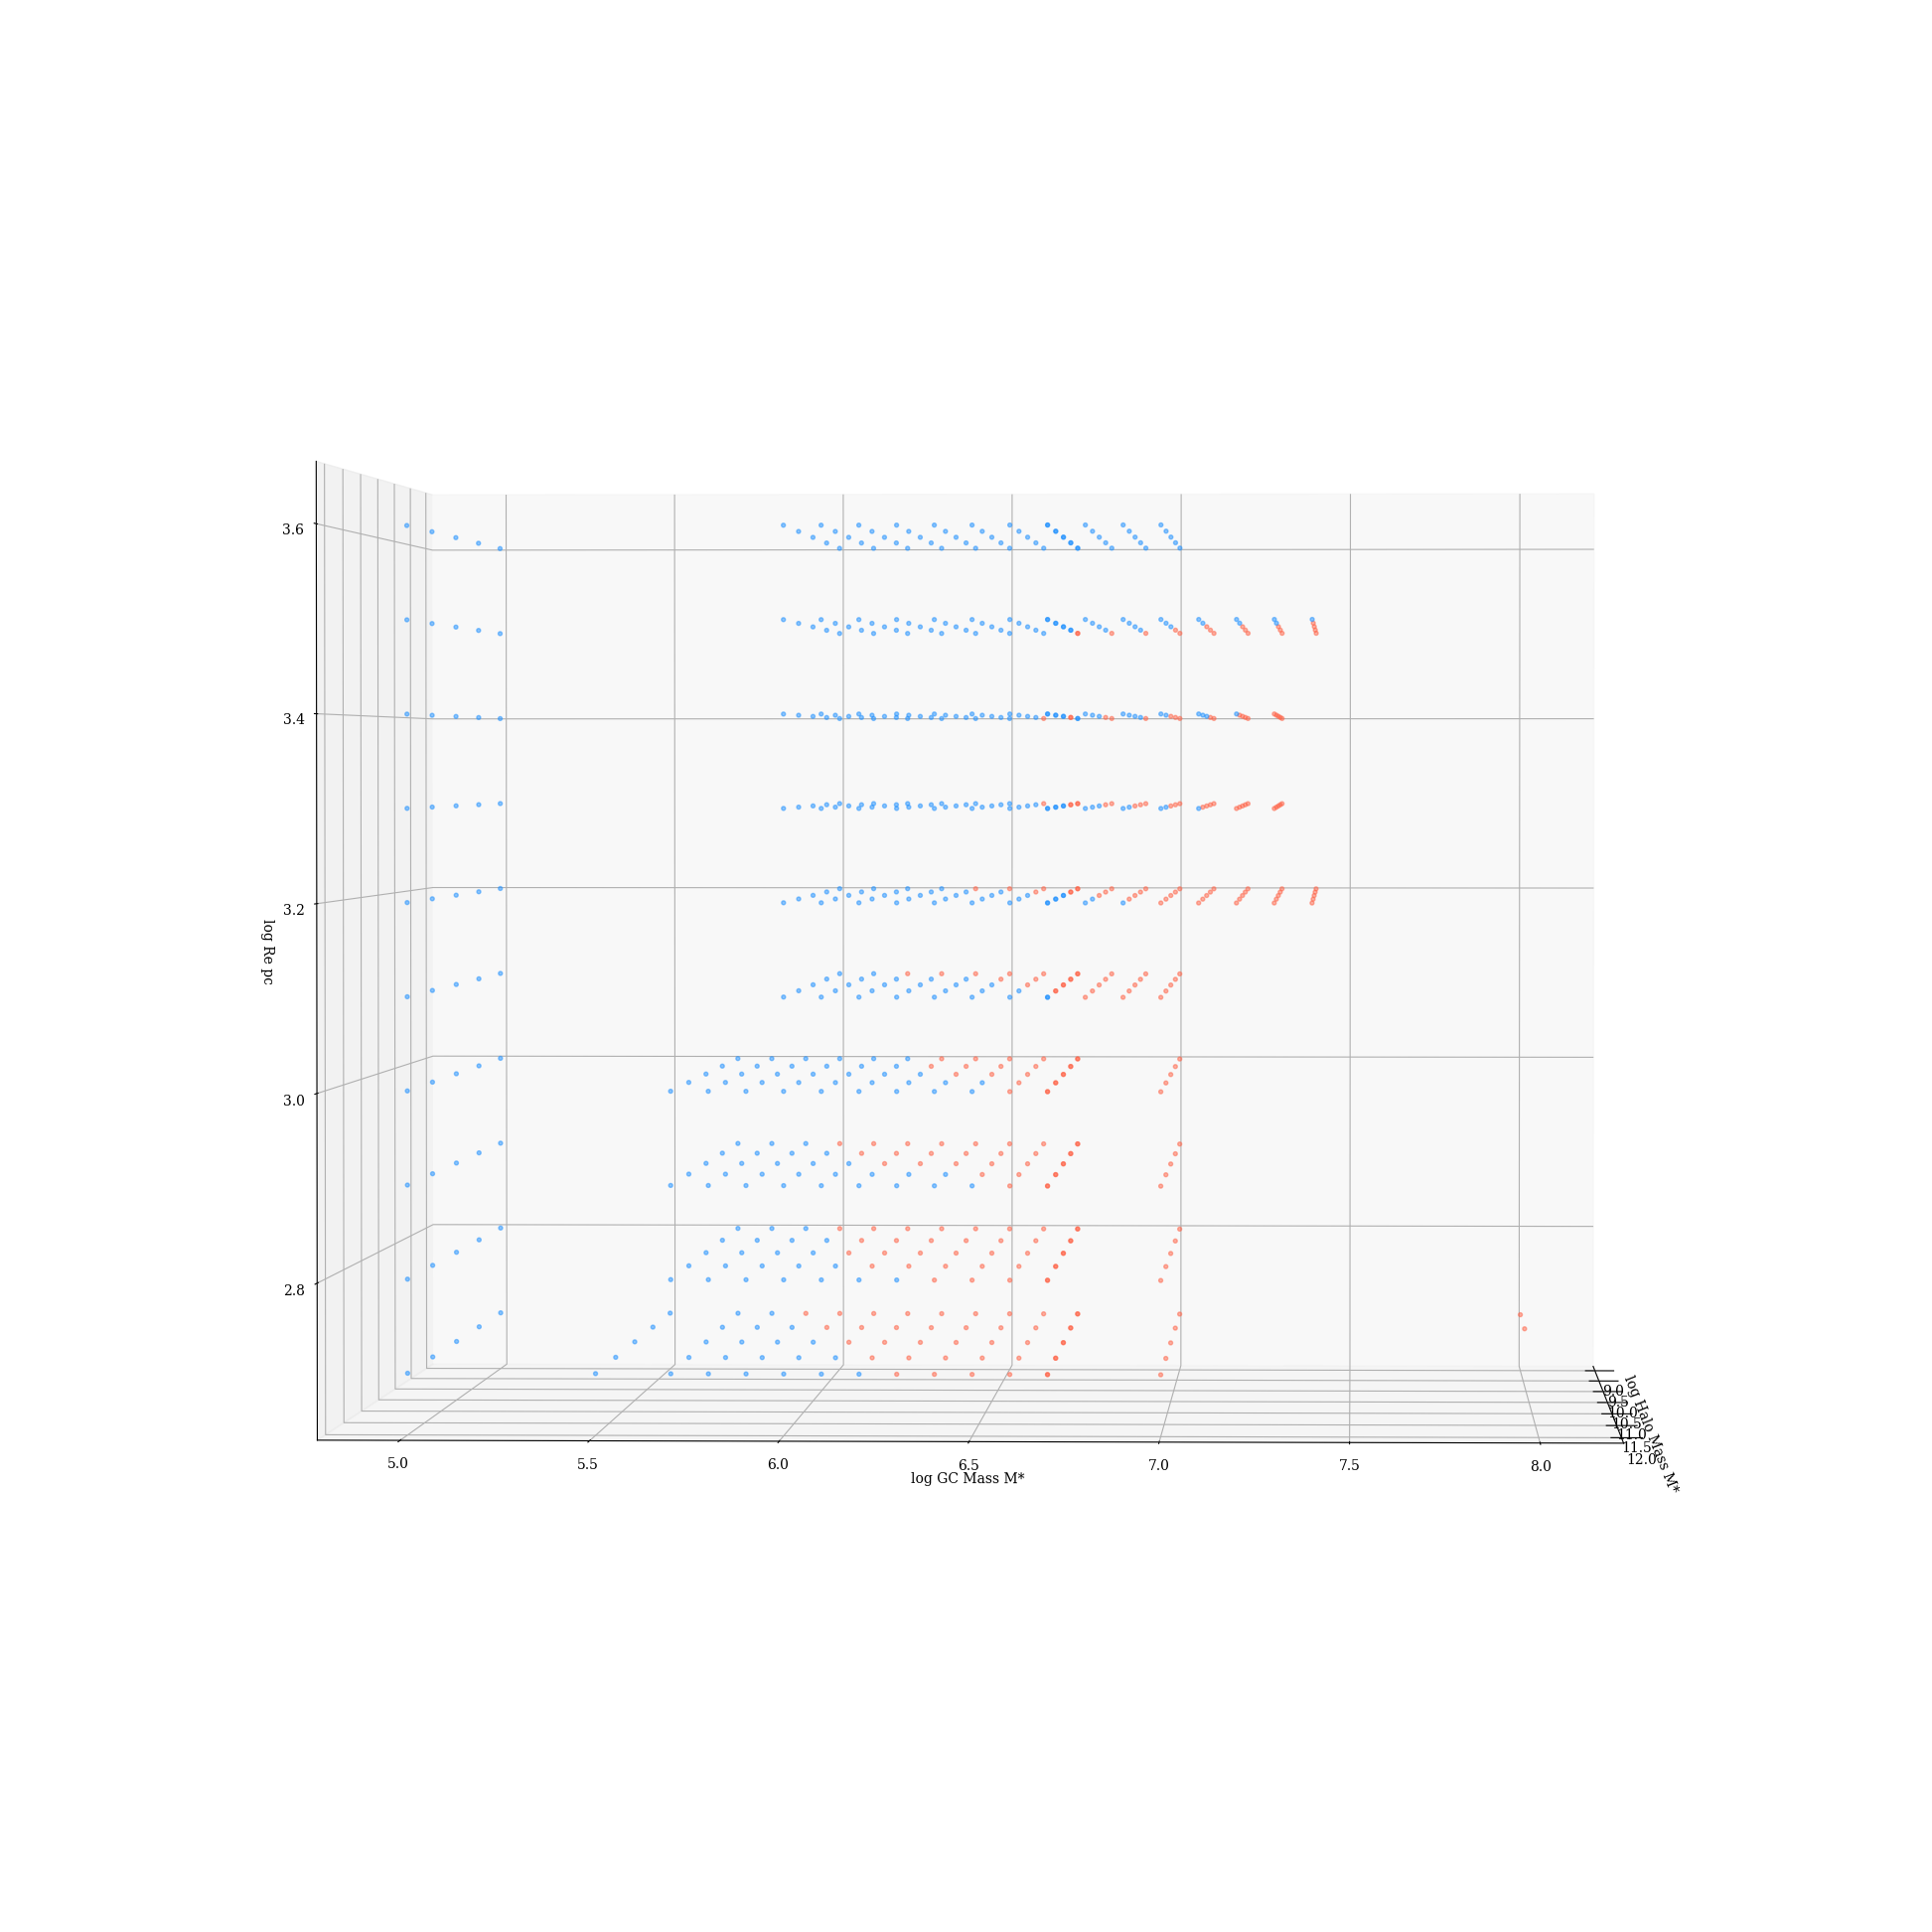

In [5]:
# Load the NumPy file
grid_data = np.load("grid_merger_classification.npy")

# Split into individual components
R_es, GC_masses, halo_masses, mergers = grid_data[:, 0], grid_data[:, 1], grid_data[:, 2], grid_data[:, 3]
# Plot loaded data
# Create 3D scatter plot
def d3_plot(R_es, GC_masses, halo_masses, mergers, elev=5, azim=183, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(25,25))
        ax = fig.add_subplot(111, projection='3d')

    if mergers is None:
        colors = 'dodgerblue'
    else:
        colors = ['tomato' if m == 1 else 'dodgerblue' for m in mergers]
    
    ax.scatter(halo_masses, GC_masses, R_es, c=colors, alpha = 0.5, s = 8)
    # ax.set_xlim(1.5, 1.7)
    ax.set_zlabel('log Re pc')
    ax.set_ylabel('log GC Mass M*')
    ax.set_xlabel('log Halo Mass M*')
    
    ax.view_init(elev=elev, azim=azim)
    
    # plt.savefig('3d_grid_plot1.png')
    
    return ax
    
d3_plot(R_es, GC_masses, halo_masses, mergers, elev=1, azim=2)


In [10]:
# Load the existing grid and classifications from the .npy file
existing_grid = np.load("grid_merger_classification.npy")  # Shape: [N, 4]

# Extract unique values for Re and halo mass from the existing grid
unique_Re = np.unique(existing_grid[:, 0])  # Column 0: log_Re
unique_halo_mass = np.unique(existing_grid[:, 2])  # Column 2: log_halo_mass

# Define the new range for GC mass
GC_mass_range = np.arange(4, 9.1, 0.1)

# Create a list for the updated grid
new_points = []

# Iterate through all combinations of Re, halo mass, and GC mass
for R_e in unique_Re:
    for halo_mass in unique_halo_mass:
        for GC_mass in GC_mass_range:
            GC_mass = np.round(GC_mass, 1)
            # Check if the point already exists in the existing grid
            exists = np.all(
                (existing_grid[:, 0] == R_e) &
                (existing_grid[:, 2] == halo_mass) &
                (existing_grid[:, 1] == GC_mass)
            )
            
            # If the point doesn't already exist, classify it
            if not exists:
                if GC_mass <= 5.6 and R_e < 3.1 and R_e!=5:
                    merger_status = 0  # Blue (no merger):
                elif GC_mass < 6 and R_e >= 3.1 and R_e!=5:
                    merger_status = 0  # Blue (no merger):
                elif GC_mass > 7 and R_e<3.2:
                    merger_status = 1  # Red (merger)
                elif GC_mass >= 7.4 and R_e < 3.5:
                    merger_status = 1  # Red (merger)
                elif GC_mass > 7 and R_e == 3.6:
                    merger_status = 0  # Blue (no merger)
                elif (GC_mass == 6.8 or GC_mass ==6.9) and R_e <= 3:
                    merger_status = 1  # Red (merger)
                elif R_e == 3.5 and GC_mass > 7.4:
                    merger_status = 1  # Red (merger)
                    
                else:
                    continue  # Skip intermediate GC mass values
                    
                    # Add the new point
                new_points.append([R_e, GC_mass, halo_mass, merger_status])
            

# Convert the new points to a NumPy array
new_points = np.array(new_points)

# Combine the existing and new grids
combined_grid = np.vstack([existing_grid, new_points])

# Save the updated grid as a .npy file
np.save("updated_grid_merger_classification.npy", combined_grid)

print("Updated grid saved to updated_grid_merger_classification.npy")


Updated grid saved to updated_grid_merger_classification.npy


<Axes3DSubplot:xlabel='log Halo Mass M*', ylabel='log GC Mass M*'>

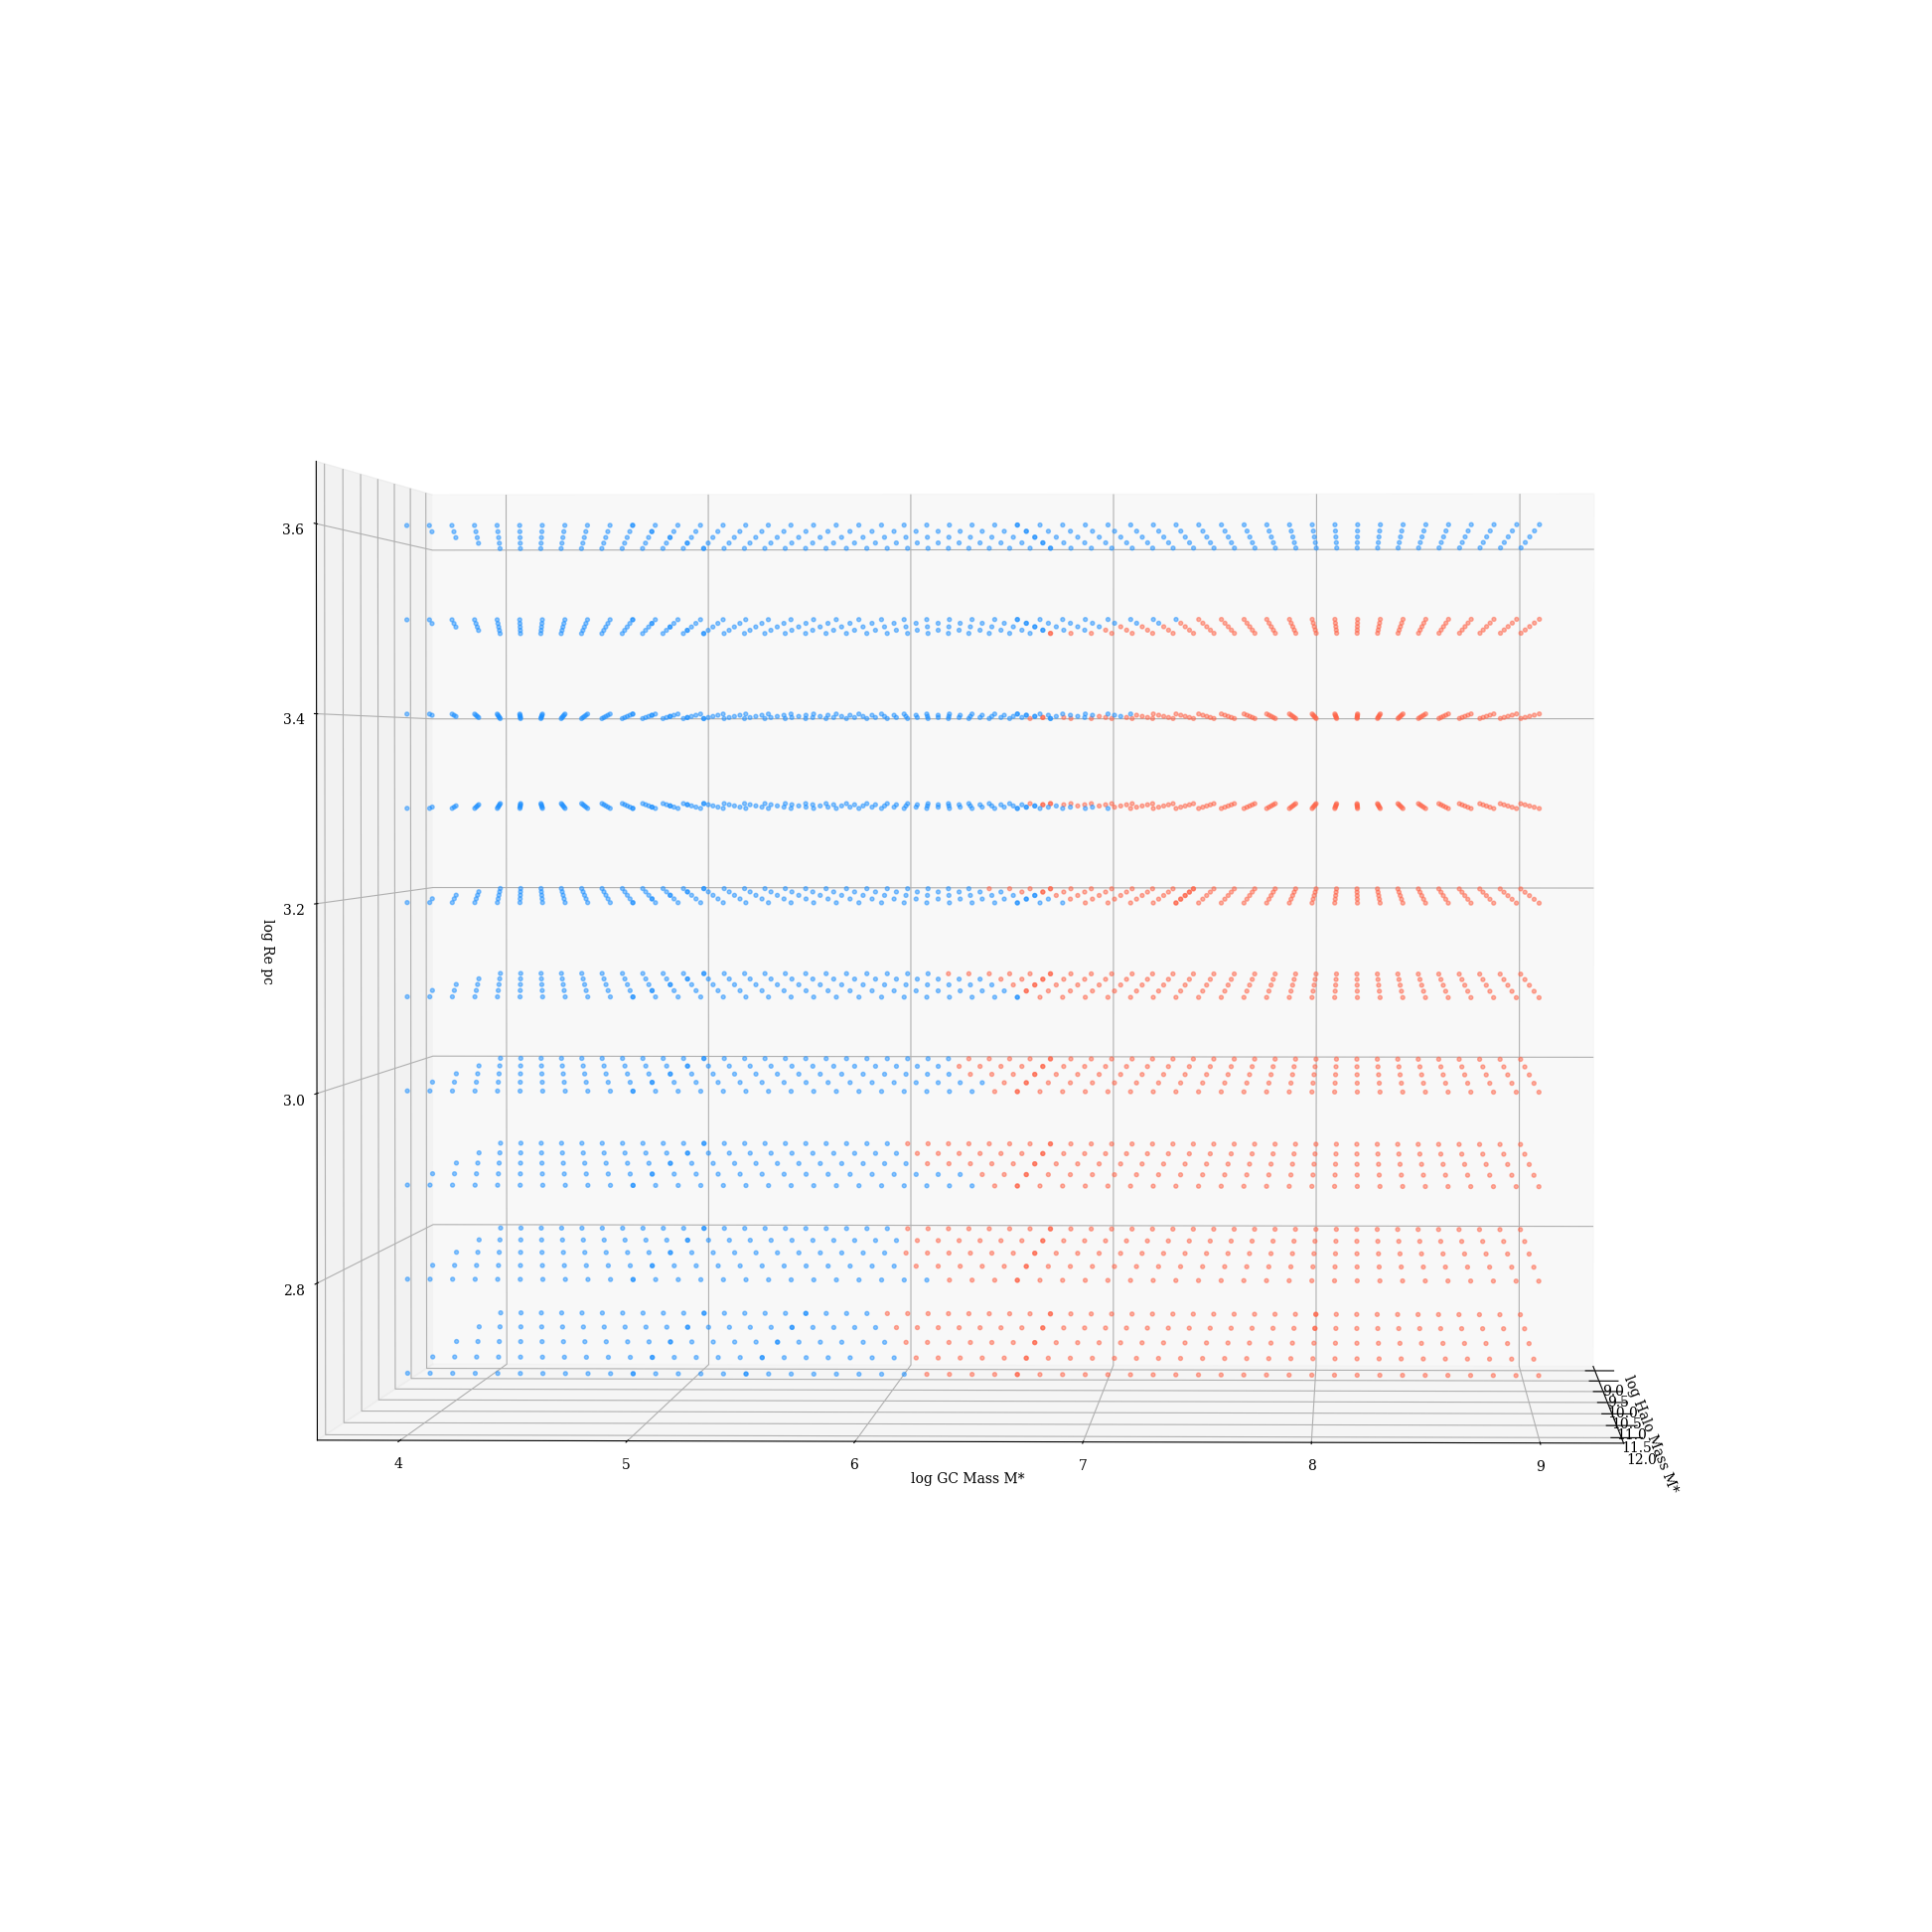

In [11]:
# Load the NumPy file
grid_data = np.load("updated_grid_merger_classification.npy")

# Split into individual components
R_es, GC_masses, halo_masses, mergers = grid_data[:, 0], grid_data[:, 1], grid_data[:, 2], grid_data[:, 3]
d3_plot(R_es, GC_masses, halo_masses, mergers, elev=1, azim=2)





# same as above but for NSC per iteration (0-10)

In [29]:
# Load the existing grid and classifications from the .npy file
existing_grid = np.load("grid_merger_classification_per_iter.npy")  # Shape: [N, 4]

# Extract unique values for Re and halo mass from the existing grid
unique_Re = np.unique(existing_grid[:, 0])  # Column 0: log_Re
unique_halo_mass = np.unique(existing_grid[:, 2])  # Column 2: log_halo_mass

# Define the new range for GC mass
GC_mass_range = np.arange(4, 9.1, 0.1)

# Create a list for the updated grid
new_points = []

# Iterate through all combinations of Re, halo mass, and GC mass
for R_e in unique_Re:
    for halo_mass in unique_halo_mass:
        for GC_mass in GC_mass_range:
            GC_mass = np.round(GC_mass, 1)
            # Check if the point already exists in the existing grid
            exists = np.all(
                (existing_grid[:, 0] == R_e) &
                (existing_grid[:, 2] == halo_mass) &
                (existing_grid[:, 1] == GC_mass)
            )
            
            # If the point doesn't already exist, classify it
            if not exists:
                if GC_mass <= 5.6 and R_e < 3.1 and R_e!=5:
                    merger_status = 0  # Blue (no merger):
                elif GC_mass < 6 and R_e >= 3.1 and R_e!=5:
                    merger_status = 0  # Blue (no merger):
                elif GC_mass > 7 and R_e<3.2:
                    merger_status = 10  # Red (merger)
                elif GC_mass >= 7.4 and R_e < 3.5:
                    merger_status = 10  # Red (merger)
                elif GC_mass > 7 and R_e == 3.6:
                    merger_status = 0  # Blue (no merger)
                elif (GC_mass == 6.8 or GC_mass ==6.9) and R_e <= 3:
                    merger_status = 10  # Red (merger)
                elif R_e == 3.5 and GC_mass > 7.4:
                    merger_status = 10  # Red (merger)
                    
                else:
                    continue  # Skip intermediate GC mass values
                    
                    # Add the new point
                new_points.append([R_e, GC_mass, halo_mass, merger_status])
            

# Convert the new points to a NumPy array
new_points = np.array(new_points)

# Combine the existing and new grids
combined_grid = np.vstack([existing_grid, new_points])

# Save the updated grid as a .npy file
np.save("updated_grid_merger_classification_per_iter.npy", combined_grid)

print("Updated grid saved to updated_grid_merger_classification_per_iter.npy")


Updated grid saved to updated_grid_merger_classification_per_iter.npy


## Samples from distribution

In [33]:
logMStellar = 9
n = 10000
all_DM_samples = np.log10(DM_random_sample(logMStellar, n))
all_Re_samples = np.log10(Re_random_sample(logMStellar, n))
all_GC_samples = np.log10(modified_GC_random_sample(logMStellar, n))
all_logMStellars = np.full(n, logMStellar)


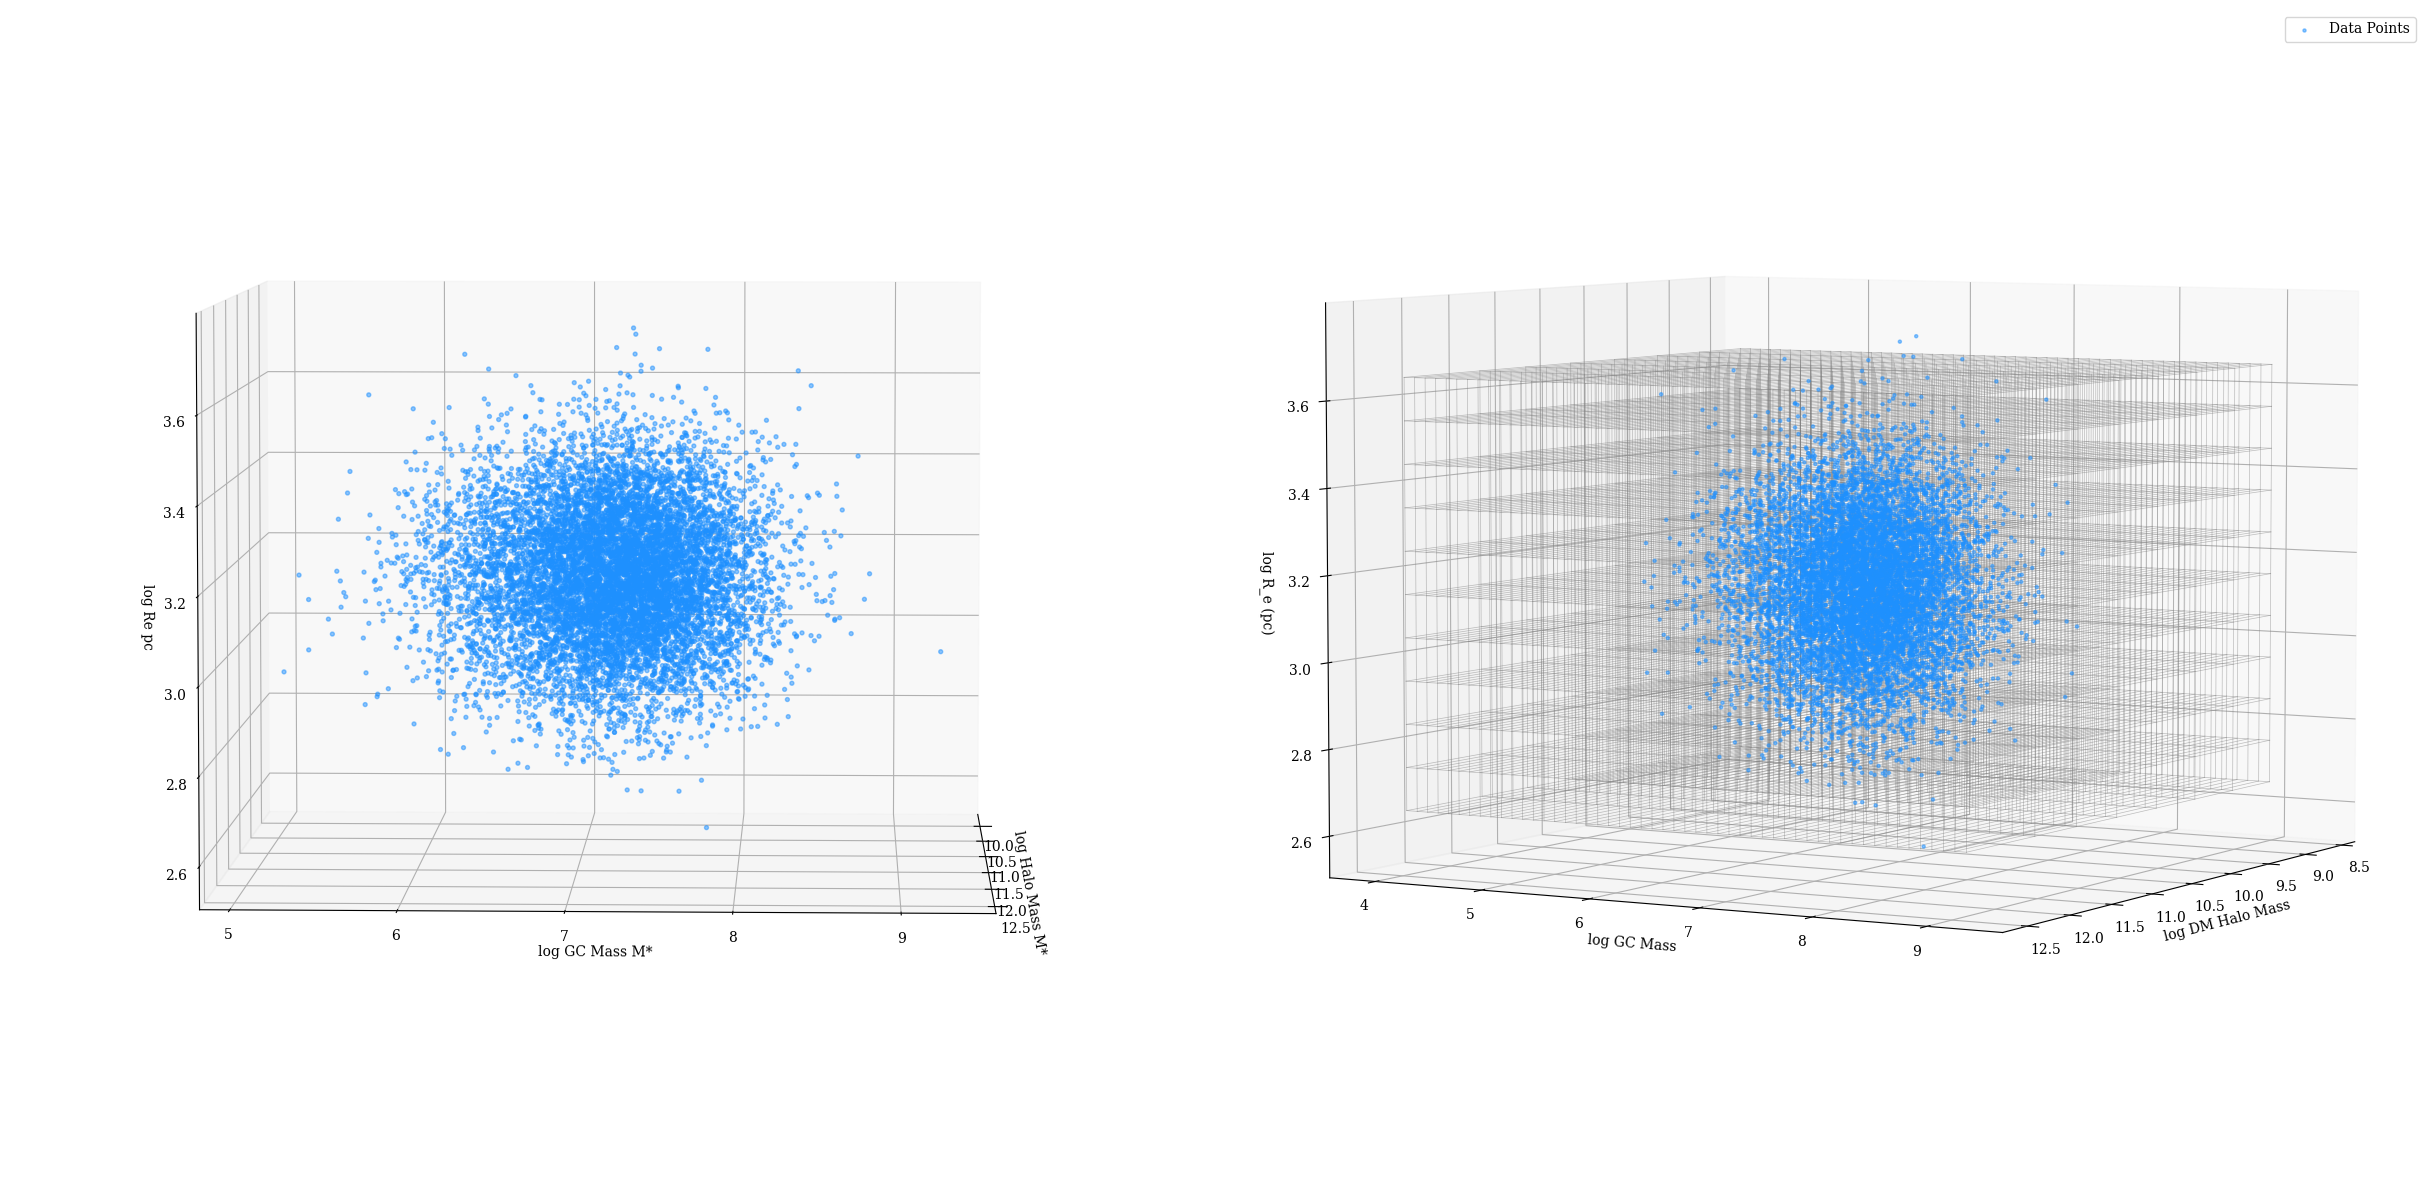

In [34]:
# Define bin centers
GC_centers = np.arange(4, 9.1, 0.1)
Re_centers = np.arange(2.7, 3.7, 0.1)
DM_centers = np.arange(9.0, 12.5, 0.5)
# GC_centers = np.arange(7, 9.1, 0.1)
# Re_centers = np.arange(2.7, 3.4, 0.1)
# DM_centers = np.arange(9.0, 12.5, 0.5)

GC_edges = np.append(GC_centers - 0.05, GC_centers[-1] + 0.05)
Re_edges = np.append(Re_centers - 0.05, Re_centers[-1] + 0.05)
DM_edges = np.append(DM_centers - 0.4, DM_centers[-1] + 0.4)


# Plot 2: With bins
def d3_plot_with_bins(GC_samples, Re_samples, DM_samples, elev=5, azim=2, ax=None):
    if ax is None:
        fig = plt.figure(figsize=(25,25))
        ax = fig.add_subplot(111, projection='3d')
    
    # Scatter plot of points
    ax.scatter(DM_samples, GC_samples, Re_samples, c='dodgerblue', alpha=0.5, s=5, label='Data Points')

    # Plot bin edges
     # Draw grid lines
    for gc_edge in GC_edges:
        for re_edge in Re_edges:
            # Vertical lines along DM axis
            ax.plot([DM_edges[0], DM_edges[-1]], [gc_edge, gc_edge], [re_edge, re_edge],
                    color='gray', alpha=0.5, linewidth=0.5)

    for gc_edge in GC_edges:
        for dm_edge in DM_edges:
            # Horizontal lines along Re axis
            ax.plot([dm_edge, dm_edge], [gc_edge, gc_edge], [Re_edges[0], Re_edges[-1]],
                    color='gray', alpha=0.5, linewidth=0.5)

    for re_edge in Re_edges:
        for dm_edge in DM_edges:
            # Vertical lines along GC axis
            ax.plot([dm_edge, dm_edge], [GC_edges[0], GC_edges[-1]], [re_edge, re_edge],
                    color='gray', alpha=0.5, linewidth=0.5)

    # Labels and viewing angle
    ax.set_xlabel('log DM Halo Mass')
    ax.set_ylabel('log GC Mass')
    ax.set_zlabel('log R_e (pc)')
    ax.view_init(elev=elev, azim=azim)
    ax.legend()
    return ax

# Create a combined plot
fig = plt.figure(figsize=(25, 12))

# Left: Scatter plot
ax1 = fig.add_subplot(121, projection='3d')
d3_plot(all_Re_samples, all_GC_samples, all_DM_samples, mergers=None, elev=5, azim=2, ax=ax1)

# Right: Binned plot
ax2 = fig.add_subplot(122, projection='3d')
d3_plot_with_bins(all_GC_samples, all_Re_samples, all_DM_samples, elev=5, azim=30, ax=ax2)

plt.tight_layout()
plt.show()


## Get fraction

In [35]:
# Load the grid data (log_Re, log_GC_mass, log_halo_mass, merger_class)
grid_data = np.load("updated_grid_merger_classification.npy")

# Split the grid data into components
log_Re = grid_data[:, 0]
log_GC_mass = grid_data[:, 1]
log_halo_mass = grid_data[:, 2]
uniform_grid = grid_data[:, 3]  # 0 (no merger) or 1 (merger)

# Filter only the merger points
merger_points = grid_data[uniform_grid == 1]

merger_Re = merger_points[:, 0]
merger_GC_mass = merger_points[:, 1]
merger_halo_mass = merger_points[:, 2]

# Count mergers in each bin
uniform_grid_counts, edges = np.histogramdd((log_GC_mass, log_Re, log_halo_mass),
                                      bins=(GC_edges, Re_edges, DM_edges))
merger_counts, edges = np.histogramdd((merger_GC_mass, merger_Re, merger_halo_mass),
                                      bins=(GC_edges, Re_edges, DM_edges))

merger_fractions = np.divide(
    merger_counts,
    uniform_grid_counts,
    out=np.zeros_like(merger_counts, dtype=float),  # Set default to 0
    where=uniform_grid_counts > 0  # Only divide where counts are non-zero
)


# Fraction of points in each bin
sample_counts, edges = np.histogramdd((all_GC_samples, all_Re_samples, all_DM_samples), 
                                         bins=(GC_edges, Re_edges, DM_edges))

sample_fractions = sample_counts / n  # get fractions

# Calculate the weighted fraction of mergers for this stellar mass
weighted_mergers = sample_fractions * merger_fractions
total_merger_fraction = np.sum(weighted_mergers)

print(f"Total merger fraction for log Mstellar = {logMStellar}: {total_merger_fraction:.4f}")


Total merger fraction for log Mstellar = 9: 0.5044


In [36]:
# import itertools

# # Generate all combinations of parameter values
# all_points = list(itertools.product(log_GC_mass, log_Re, log_halo_mass))

# # Check for duplicates
# unique_points = set(all_points)
# print(f"Total points: {len(all_points)}")
# print(f"Unique points: {len(unique_points)}")


# DEBUGGING

In [48]:
median_Re = np.median(all_Re_samples)
median_GC = np.median(all_GC_samples)
median_halo = np.median(all_DM_samples)

bin_index_Re = np.digitize(median_Re, Re_edges) - 1
bin_index_GC = np.digitize(median_GC, GC_edges) - 1
bin_index_DM = np.digitize(median_halo, DM_edges) - 1

bin_index = (bin_index_GC, bin_index_Re, bin_index_DM)

local_nsc_fraction = merger_fractions[bin_index]
print(f"NSC fraction for bin containing median values: {local_nsc_fraction}")

count_sample_points = sample_counts[bin_index]
print(f"Number of sample points in bin: {count_sample_points}")

fraction_sample_points = sample_fractions[bin_index]
print(f"Fraction of sample points in bin: {fraction_sample_points}")

num_uniform_points = uniform_grid_counts[bin_index]
print(f"Number of uniform grid points in bin: {num_uniform_points}")


NSC fraction for bin containing median values: 1.0
Number of sample points in bin: 105.0
Fraction of sample points in bin: 0.01682962013143132
Number of uniform grid points in bin: 1.0


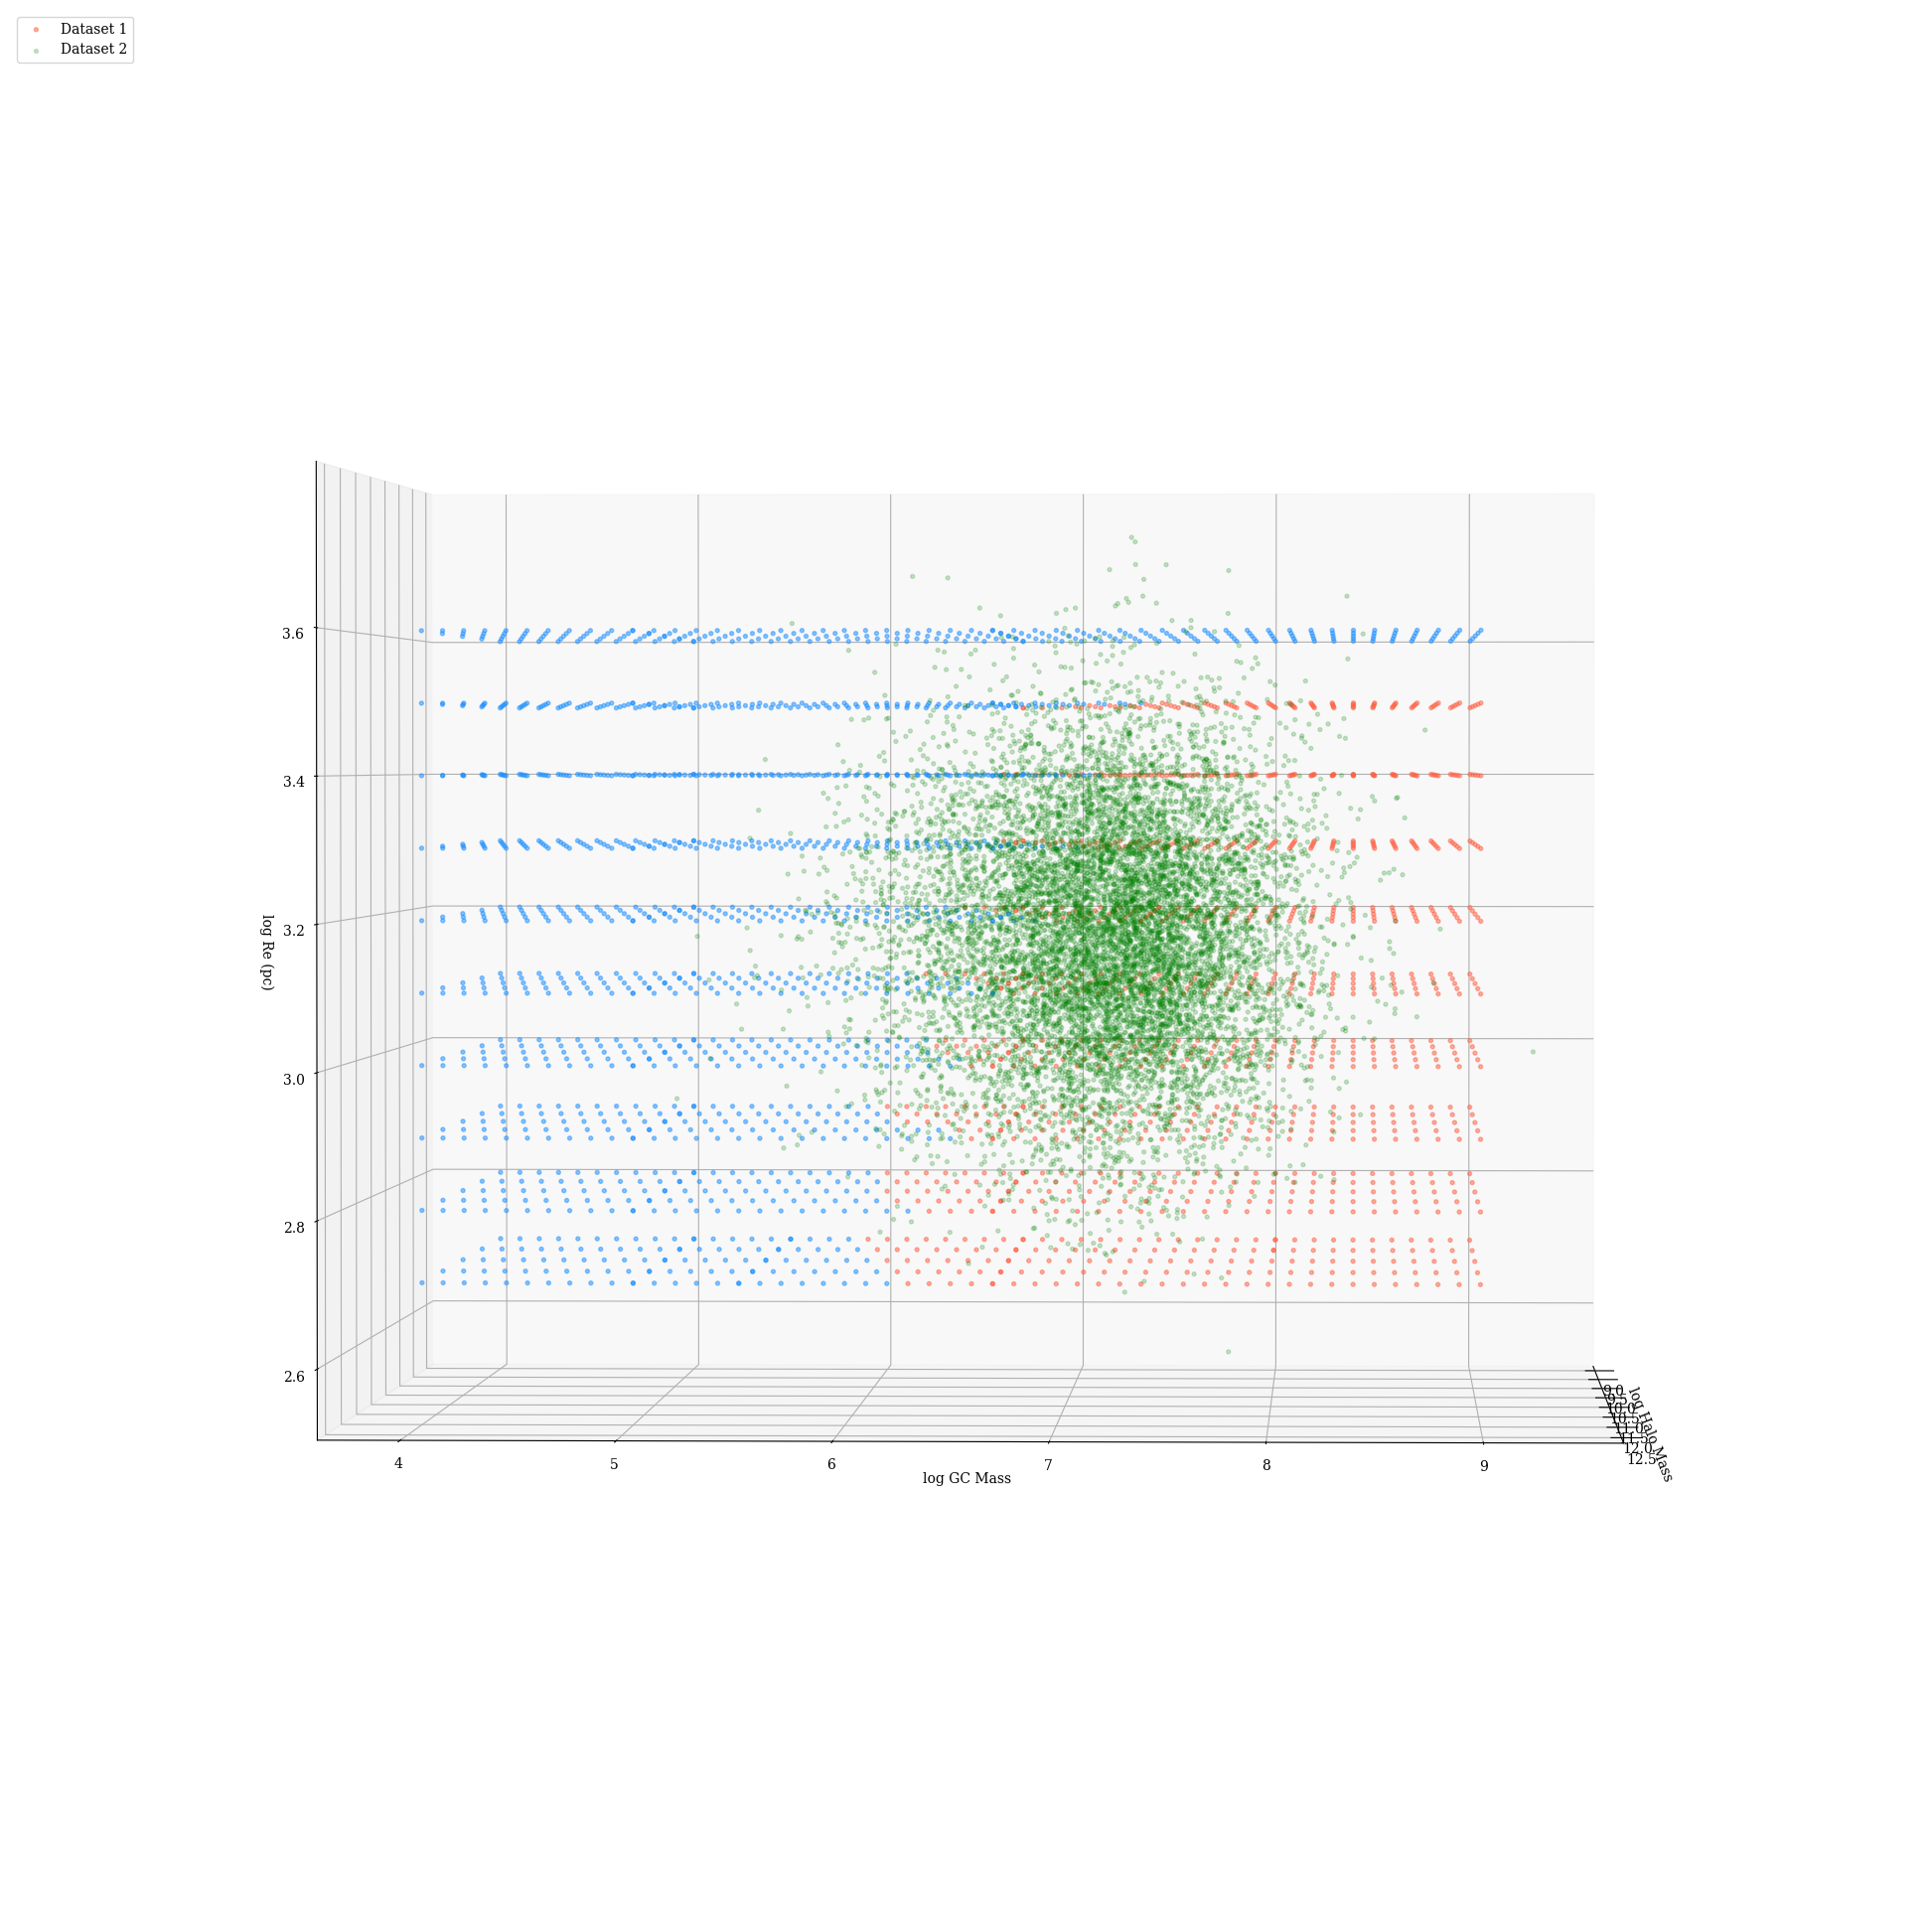

In [37]:
# Load the NumPy file
grid_data = np.load("updated_grid_merger_classification.npy")

# Split into individual components
R_es, GC_masses, halo_masses, mergers = grid_data[:, 0], grid_data[:, 1], grid_data[:, 2], grid_data[:, 3]


def combined_d3_plot(
    R_es1, GC_masses1, halo_masses1, mergers1,
    R_es2, GC_masses2, halo_masses2, mergers2=None,
    elev=1, azim=2
):
    fig = plt.figure(figsize=(25, 25))
    ax = fig.add_subplot(111, projection='3d')

    # Plot first dataset
    if mergers1 is not None:
        colors1 = ['tomato' if m == 1 else 'dodgerblue' for m in mergers1]
    else:
        colors1 = 'blue'
    ax.scatter(halo_masses1, GC_masses1, R_es1, c=colors1, alpha=0.5, s=8, label='Dataset 1')

    # Plot second dataset
    if mergers2 is not None:
        colors2 = ['tomato' if m == 1 else 'dodgerblue' for m in mergers2]
    else:
        colors2 = 'green'
    ax.scatter(halo_masses2, GC_masses2, R_es2, c=colors2, alpha=0.2, s=8, label='Dataset 2')

    # Labels and viewing angle
    ax.set_xlabel('log Halo Mass')
    ax.set_ylabel('log GC Mass')
    ax.set_zlabel('log Re (pc)')
    ax.view_init(elev=elev, azim=azim)

    # Legend
    ax.legend(loc='upper left')
    plt.show()

# Call the combined plot function
combined_d3_plot(
    R_es, GC_masses, halo_masses, mergers,
    all_Re_samples, all_GC_samples, all_DM_samples, None,
    elev=1, azim=2
)


In [45]:
print("Shape of uniform_grid_counts:", uniform_grid_counts.shape)
print("Shape of merger_counts:", merger_counts.shape)
print("Shape of sample_fractions:", sample_fractions.shape)

print("Total counts in uniform grid:", np.sum(uniform_grid_counts))
print("Total counts in merger grid:", np.sum(merger_counts))
print("Total sampled points:", np.sum(sample_counts))

print("Max and Min of merger_fractions:", np.max(merger_fractions), np.min(merger_fractions))
print("Weighted mergers shape:", weighted_mergers.shape)


Shape of uniform_grid_counts: (51, 10, 7)
Shape of merger_counts: (51, 10, 7)
Shape of sample_fractions: (51, 10, 7)
Total counts in uniform grid: 2647.0
Total counts in merger grid: 1151.0
Total sampled points: 9985.0
Max and Min of merger_fractions: 1.0 0.0
Weighted mergers shape: (51, 10, 7)


In [46]:
print("GC samples out of bounds:", np.sum((all_GC_samples < GC_edges[0]) | (all_GC_samples > GC_edges[-1])))
print("Re samples out of bounds:", np.sum((all_Re_samples < Re_edges[0]) | (all_Re_samples > Re_edges[-1])))
print("DM samples out of bounds:", np.sum((all_DM_samples < DM_edges[0]) | (all_DM_samples > DM_edges[-1])))


GC samples out of bounds: 0
Re samples out of bounds: 13
DM samples out of bounds: 2


In [47]:
print("Merger fractions for first bin:", merger_fractions[0, 0, 0])
print("Sample fractions for first bin:", sample_fractions[0, 0, 0])
print("Uniform grid counts for first bin:", uniform_grid_counts[0, 0, 0])
print("Merger counts for first bin:", merger_counts[0, 0, 0])


Merger fractions for first bin: 0.0
Sample fractions for first bin: 0.0
Uniform grid counts for first bin: 1.0
Merger counts for first bin: 0.0


In [48]:
print("Weighted mergers (sum over GC, Re, DM):", np.sum(weighted_mergers, axis=(0, 1, 2)))


Weighted mergers (sum over GC, Re, DM): 0.797243147940375


In [49]:
non_zero_bins = np.where((sample_fractions > 0) & (merger_fractions > 0))
print("Non-zero bins indices:", non_zero_bins)
print("Merger fractions in these bins:", merger_fractions[non_zero_bins])
print("Sample fractions in these bins:", sample_fractions[non_zero_bins])


Non-zero bins indices: (array([22, 23, 24, 24, 25, 25, 25, 26, 26, 26, 26, 26, 26, 26, 26, 27, 27,
       27, 27, 27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 28, 28,
       28, 28, 28, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 30,
       30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 32,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 32, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35,
       35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37,
       37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38,
 

In [52]:
print("Uniform grid non-zero counts:", np.count_nonzero(uniform_grid_counts))
print("Max count in uniform grid:", np.max(uniform_grid_counts))


Uniform grid non-zero counts: 2535
Max count in uniform grid: 2.0


In [53]:
total_samples_in_bins = np.sum(sample_fractions)
print("Sum of sample fractions (should be ~1):", total_samples_in_bins)


Sum of sample fractions (should be ~1): 1.6004167334508737


In [63]:
# Check total number of grid points in each bin
print("Uniform Grid Counts Shape:", uniform_grid_counts.shape)

# Total number of non-zero bins
non_zero_bins = np.count_nonzero(uniform_grid_counts)
print(f"Number of non-zero bins: {non_zero_bins}")

# Total points across all bins
total_uniform_points = np.sum(uniform_grid_counts)
print(f"Total uniform grid points: {total_uniform_points}")

# Maximum number of points in any bin
max_points_per_bin = np.max(uniform_grid_counts)
print(f"Maximum points in any bin: {max_points_per_bin}")

# Count bins with exactly one point
bins_with_one_point = np.sum(uniform_grid_counts == 1)

print(f"Number of bins with exactly one point: {bins_with_one_point}")

Uniform Grid Counts Shape: (51, 10, 7)
Number of non-zero bins: 2535
Total uniform grid points: 2647.0
Maximum points in any bin: 2.0
Number of bins with exactly one point: 2423


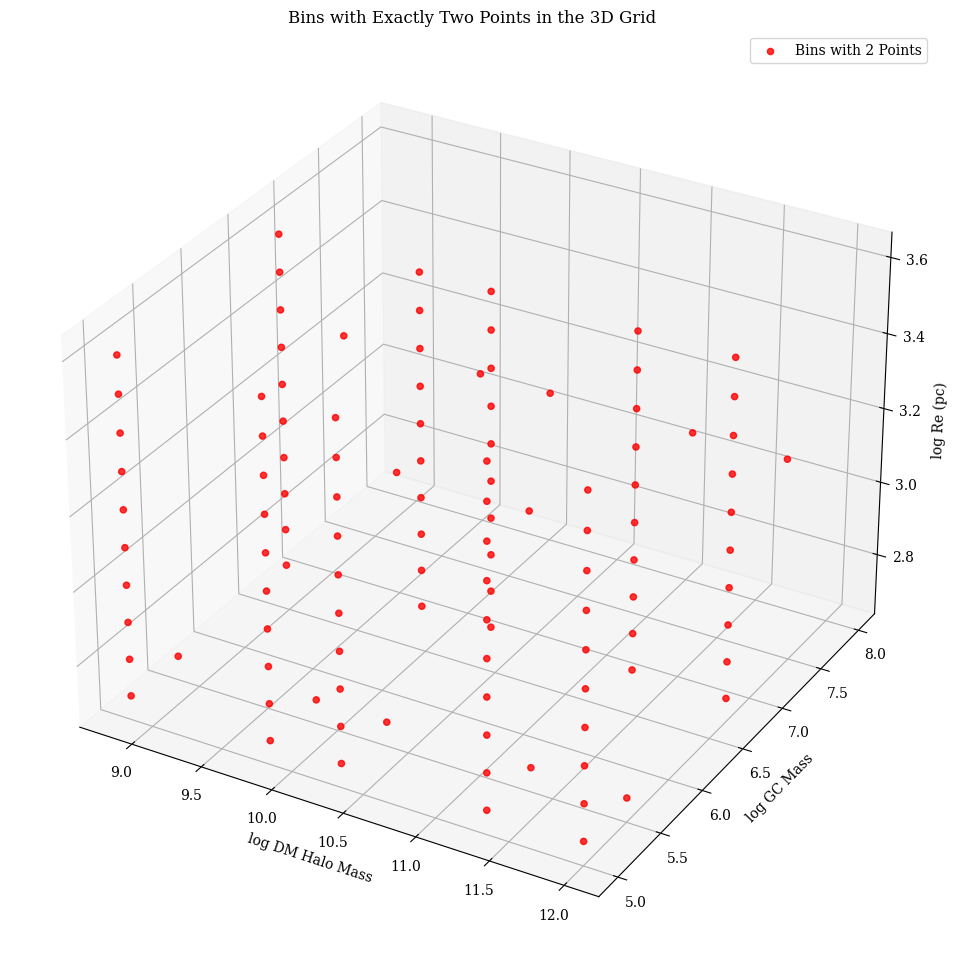

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Get the indices of bins with exactly 2 points
indices_with_two_points = np.argwhere(uniform_grid_counts == 2)

# Extract the bin centers for visualization
GC_centers = 0.5 * (GC_edges[:-1] + GC_edges[1:])
Re_centers = 0.5 * (Re_edges[:-1] + Re_edges[1:])
DM_centers = 0.5 * (DM_edges[:-1] + DM_edges[1:])

# Get the coordinates of these bins
GC_bins = GC_centers[indices_with_two_points[:, 0]]
Re_bins = Re_centers[indices_with_two_points[:, 1]]
DM_bins = DM_centers[indices_with_two_points[:, 2]]

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot the bins with two points
ax.scatter(DM_bins, GC_bins, Re_bins, c='red', s=20, label="Bins with 2 Points", alpha=0.8)

# Labels and viewing angles
ax.set_xlabel('log DM Halo Mass')
ax.set_ylabel('log GC Mass')
ax.set_zlabel('log Re (pc)')
ax.set_title('Bins with Exactly Two Points in the 3D Grid')
ax.legend()
plt.show()


In [ ]:
import itertools

# Generate all combinations of parameter values
all_points = list(itertools.product(GC_masses, R_es, halo_masses))

# Check for duplicates
unique_points = set(all_points)
print(f"Total points: {len(all_points)}")
print(f"Unique points: {len(unique_points)}")
